In [1]:
import joblib
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import Counter
import math
import random
import string
import collections

In [4]:
# Feature extraction functions...
def character_frequency(ciphertext):
    return Counter(ciphertext)

def bigram_frequency(ciphertext):
    return Counter([ciphertext[i:i+2] for i in range(len(ciphertext) - 1)])

def trigram_frequency(ciphertext):
    return Counter([ciphertext[i:i+3] for i in range(len(ciphertext) - 2)])

def index_of_coincidence(ciphertext):
    freq = character_frequency(ciphertext)
    N = len(ciphertext)
    return sum(f * (f - 1) for f in freq.values()) / (N * (N - 1))

def entropy(ciphertext):
    freq = character_frequency(ciphertext)
    N = len(ciphertext)
    return -sum(f/N * math.log2(f/N) for f in freq.values() if f > 0)

def repeated_substrings(ciphertext):
    return [ciphertext[i:i+3] for i in range(len(ciphertext) - 3) if ciphertext.count(ciphertext[i:i+3]) > 1]

def ciphertext_length(ciphertext):
    return len(ciphertext)

def hamming_distance(s1, s2):
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

def kasiski_examination(ciphertext):
    repeated_patterns = repeated_substrings(ciphertext)
    distances = [ciphertext.find(pat, i+1) - i for i, pat in enumerate(repeated_patterns)]
    return math.gcd(*distances) if distances else None

def friedman_test(ciphertext):
    ic = index_of_coincidence(ciphertext)
    return 1 / (1 - ic) if ic != 1 else float('inf')

def has_letter_j(text):
    return int('J' in text.upper())  # Ensure case insensitivity

ENGLISH_FREQ = {
    'A': 8.167, 'B': 1.492, 'C': 2.782, 'D': 4.253, 'E': 12.702, 'F': 2.228, 'G': 2.015, 'H': 6.094, 
    'I': 6.966, 'J': 0.153, 'K': 0.772, 'L': 4.025, 'M': 2.406, 'N': 6.749, 'O': 7.507, 'P': 1.929, 
    'Q': 0.095, 'R': 5.987, 'S': 6.327, 'T': 9.056, 'U': 2.758, 'V': 0.978, 'W': 2.360, 'X': 0.150, 
    'Y': 1.974, 'Z': 0.074
}

def digraphic_index_of_coincidence(ciphertext):
    # Count bigram frequencies
    bigram_freq = bigram_frequency(ciphertext)
    N = len(ciphertext) // 2  # Total number of bigrams
    if N <= 1:
        return 0  # Avoid division by zero if ciphertext is too short for bigrams

    # Compute the Digraphic Index of Coincidence
    return sum(f * (f - 1) for f in bigram_freq.values()) / (N * (N - 1))
def is_triple_polygraphic_substitution(ciphertext):
    
    ciphertext = ''.join(filter(str.isalpha, ciphertext)).upper()
    
    digraph_counts = collections.Counter(ciphertext[i:i+2] for i in range(len(ciphertext) - 1))
    
    # Count unique digraphs
    unique_digraphs = len(digraph_counts)
    
    # Calculate the average frequency of digraphs
    total_digraphs = sum(digraph_counts.values())
    average_digraph_frequency = total_digraphs / unique_digraphs if unique_digraphs > 0 else 0
    
    threshold = 1  # Adjust threshold based on your dataset characteristics
    if average_digraph_frequency > threshold:
        return 1
    else:
        return 0
def digraph_frequency_analysis(ciphertext):
    digraphs = [ciphertext[i:i+2] for i in range(len(ciphertext) - 1)]
    digraph_freq = Counter(digraphs)
    total_digraphs = sum(digraph_freq.values())
    if total_digraphs == 0:
        return 0
    return max(digraph_freq.values()) / total_digraphs  # Feature: Frequency of most common digraph
def extract_features(ciphertext):
    bigram_counts = bigram_frequency(ciphertext)
    trigram_counts = trigram_frequency(ciphertext)
    
    # Define all possible bigrams and trigrams
    all_bigrams = [a+b for a in string.ascii_uppercase for b in string.ascii_uppercase]
    all_trigrams = [a+b+c for a in string.ascii_uppercase for b in string.ascii_uppercase for c in string.ascii_uppercase]
    
    bigram_features = [bigram_counts.get(bigram, 0) for bigram in all_bigrams]
    trigram_features = [trigram_counts.get(trigram, 0) for trigram in all_trigrams]

    binary_features = [
        has_letter_j(ciphertext)
    ]
    #digraphic_ic = digraphic_index_of_coincidence(ciphertext)
      # Return combined feature vector
    return [
        ciphertext_length(ciphertext),
        entropy(ciphertext),
        index_of_coincidence(ciphertext),
        #digraphic_ic,  # Include Digraphic Index of Coincidence here
        len(repeated_substrings(ciphertext)),
        friedman_test(ciphertext),
        digraph_frequency_analysis(ciphertext),
        is_triple_polygraphic_substitution(ciphertext),
        *bigram_features,
        *trigram_features,
        *binary_features  # Add new features at the end
    ]

In [5]:
def generate_transposition_cipher(plaintext, key=5):
    # Split plaintext into columns based on key
    grid = [''] * key
    for i, char in enumerate(plaintext):
        grid[i % key] += char
    return ''.join(grid)

def generate_playfair_cipher(plaintext, key="PLAYFAIRKEY"):
    # Create 5x5 matrix for the key, excluding 'J'
    alphabet = string.ascii_uppercase.replace("J", "")
    key = ''.join(sorted(set(key.upper()), key=lambda x: key.index(x)))
    matrix = [char for char in key if char in alphabet] + [char for char in alphabet if char not in key]

    def find_position(letter):
        index = matrix.index(letter)
        return index // 5, index % 5

    def encrypt_bigram(bigram):
        row1, col1 = find_position(bigram[0])
        row2, col2 = find_position(bigram[1])
        if row1 == row2:
            return matrix[row1 * 5 + (col1 + 1) % 5] + matrix[row2 * 5 + (col2 + 1) % 5]
        elif col1 == col2:
            return matrix[((row1 + 1) % 5) * 5 + col1] + matrix[((row2 + 1) % 5) * 5 + col2]
        else:
            return matrix[row1 * 5 + col2] + matrix[row2 * 5 + col1]

    plaintext = plaintext.upper().replace("J", "I")
    ciphertext = []
    for i in range(0, len(plaintext), 2):
        bigram = plaintext[i:i+2] if len(plaintext[i:i+2]) == 2 else plaintext[i] + 'X'
        ciphertext.append(encrypt_bigram(bigram))
    return ''.join(ciphertext)
     
def generate_scytale_cipher(plaintext, key=5):
    # Transposition cipher where the key defines the number of rows
    ciphertext = [''] * key
    for i, char in enumerate(plaintext):
        ciphertext[i % key] += char
    return ''.join(ciphertext)

def generate_vigenere_cipher(plaintext, key="KEYWORD"):
    key = key.upper()
    ciphertext = []
    key_index = 0
    for char in plaintext:
        if char.isalpha():
            shift = ord(key[key_index]) - ord('A')
            cipher_char = chr(((ord(char) - ord('A') + shift) % 26) + ord('A'))
            ciphertext.append(cipher_char)
            key_index = (key_index + 1) % len(key)
        else:
            ciphertext.append(char)
    return ''.join(ciphertext)

def generate_trisquare_cipher(plaintext):
    alphabet = string.ascii_uppercase.replace("J", "")
    square1 = ''.join(random.sample(alphabet, len(alphabet)))
    square2 = ''.join(random.sample(alphabet, len(alphabet)))
    square3 = ''.join(random.sample(alphabet, len(alphabet)))

    def get_position(letter, square):
        index = square.index(letter)
        return index // 5, index % 5

    def encrypt_bigram(bigram):
        row1, col1 = get_position(bigram[0], square1)
        row2, col2 = get_position(bigram[1], square2)
        return square3[row1 * 5 + col2] + square3[row2 * 5 + col1]

    plaintext = plaintext.upper().replace("J", "I")
    ciphertext = []
    for i in range(0, len(plaintext), 2):
        if i + 1 < len(plaintext):
            bigram = plaintext[i:i+2]
            ciphertext.append(encrypt_bigram(bigram))
        else:
            ciphertext.append(plaintext[i])
    return ''.join(ciphertext)

def generate_swagman_cipher(plaintext, key=4):
    grid = [''] * key
    for i, char in enumerate(plaintext):
        grid[i % key] += char
    return ''.join(grid)

def generate_amsco_cipher(plaintext, period=4):
    rows = [''] * period
    i = 0
    for index, char in enumerate(plaintext):
        rows[i] += char
        if index % 2 == 0:
            i = (i + 1) % period
        else:
            i = (i + 2) % period
    return ''.join(rows)

def generate_autokey_cipher(plaintext, key):
    key = key.upper()
    ciphertext = []
    key_index = 0
    for char in plaintext:
        if char.isalpha():
            shift = ord(key[key_index]) - ord('A')
            cipher_char = chr(((ord(char) - ord('A') + shift) % 26) + ord('A'))
            ciphertext.append(cipher_char)
            key_index = (key_index + 1) % len(key)
        else:
            ciphertext.append(char)
    return ''.join(ciphertext)

def generate_baconian_cipher(plaintext):
    baconian_alphabet = {
        'A': 'AAAAA', 'B': 'AAAAB', 'C': 'AAABA', 'D': 'AAABB', 'E': 'AABAA',
        'F': 'AABAB', 'G': 'AABBA', 'H': 'AABBB', 'I': 'ABAAA', 'J': 'ABAAB',
        'K': 'ABABA', 'L': 'ABABB', 'M': 'ABBAA', 'N': 'ABBAB', 'O': 'ABBBB',
        'P': 'BAAAA', 'Q': 'BAAAB', 'R': 'BAABA', 'S': 'BAABB', 'T': 'BABAA',
        'U': 'BABAB', 'V': 'BABBA', 'W': 'BABBB', 'X': 'BBAAA', 'Y': 'BBAAB',
        'Z': 'BBABA'
    }
    plaintext = plaintext.upper()
    return ''.join(baconian_alphabet.get(char, '') for char in plaintext if char in baconian_alphabet)

def generate_bazeries_cipher(plaintext):
    # Simple substitution cipher with random permutations
    substitution = ''.join(random.sample(string.ascii_uppercase, 26))
    trans_table = str.maketrans(string.ascii_uppercase, substitution)
    return plaintext.upper().translate(trans_table)

def generate_beaufort_cipher(plaintext, period=10):
    def beaufort_encrypt_char(c, key_char):
        return chr(((ord(key_char) - ord(c)) % 26) + ord('A'))
    
    key = 'KEY'  # Simple key for demonstration
    ciphertext = []
    key_length = len(key)
    
    for i, char in enumerate(plaintext.upper()):
        if char.isalpha():
            encrypted_char = beaufort_encrypt_char(char, key[i % key_length])
            ciphertext.append(encrypted_char)
        else:
            ciphertext.append(char)
    
    return ''.join(ciphertext)

def checkerboard_cipher_encrypt(plaintext,key):
    # Checkerboard grid (key): You can customize this to any mapping
    grid = {
        'A': '11', 'B': '12', 'C': '13', 'D': '14', 'E': '15', 'F': '16',
        'G': '21', 'H': '22', 'I': '23', 'J': '24', 'K': '25', 'L': '26',
        'M': '31', 'N': '32', 'O': '33', 'P': '34', 'Q': '35', 'R': '36',
        'S': '41', 'T': '42', 'U': '43', 'V': '44', 'W': '45', 'X': '46',
        'Y': '51', 'Z': '52', ' ': '53', '.': '54', ',': '55', '0': '56',
        '1': '61', '2': '62', '3': '63', '4': '64', '5': '65', '6': '66',
        '7': '71', '8': '72', '9': '73'
    }
    
    # Convert plaintext to uppercase for simplicity
    plaintext = plaintext.upper()
    
    # Encrypt plaintext using the checkerboard grid
    ciphertext = ''.join(grid[char] if char in grid else char for char in plaintext)
    
    return ciphertext

def generate_cipher_sample(algorithm, length):
    plaintext = ''.join(random.choices(string.ascii_uppercase, k=length))
    
    if algorithm == "AMSCO":
        return generate_amsco_cipher(plaintext)
    elif algorithm == "AUTOKEY":
        key = ''.join(random.choices(string.ascii_uppercase, k=10))  # Random key
        return generate_autokey_cipher(plaintext, key)
    elif algorithm == "BACONIAN":
        return generate_baconian_cipher(plaintext)
    elif algorithm == "BAZERIES":
        return generate_bazeries_cipher(plaintext)
    elif algorithm == "BEAUFORT":
        return generate_beaufort_cipher(plaintext)
    elif algorithm == "VIGENERE":
        return generate_vigenere_cipher(plaintext)
    elif algorithm == "TRISQUARE":
        return generate_trisquare_cipher(plaintext)
    elif algorithm == "CHECKERBOARD":
        key_length = 6
        key = ''.join(random.choices(string.ascii_uppercase, k=key_length))
        return checkerboard_cipher_encrypt(plaintext,key)
    elif algorithm == "PLAYFAIR":
        return generate_playfair_cipher(plaintext)
    elif algorithm == "SCYTALE":
        return generate_scytale_cipher(plaintext)
    else:
        return "UNKNOWN_CIPHER"
# Prepare Data
cipher_data = []
cipher_labels = []

algorithms = ["AMSCO", "AUTOKEY", "BACONIAN", "BAZERIES", "BEAUFORT", "VIGENERE", "TRISQUARE", "CHECKERBOARD", "PLAYFAIR", "SCYTALE"]

for algorithm in algorithms:
    for _ in range(2500):
        sample = generate_cipher_sample(algorithm, length=128)
        features = extract_features(sample)
        cipher_data.append(features)
        cipher_labels.append(algorithm)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


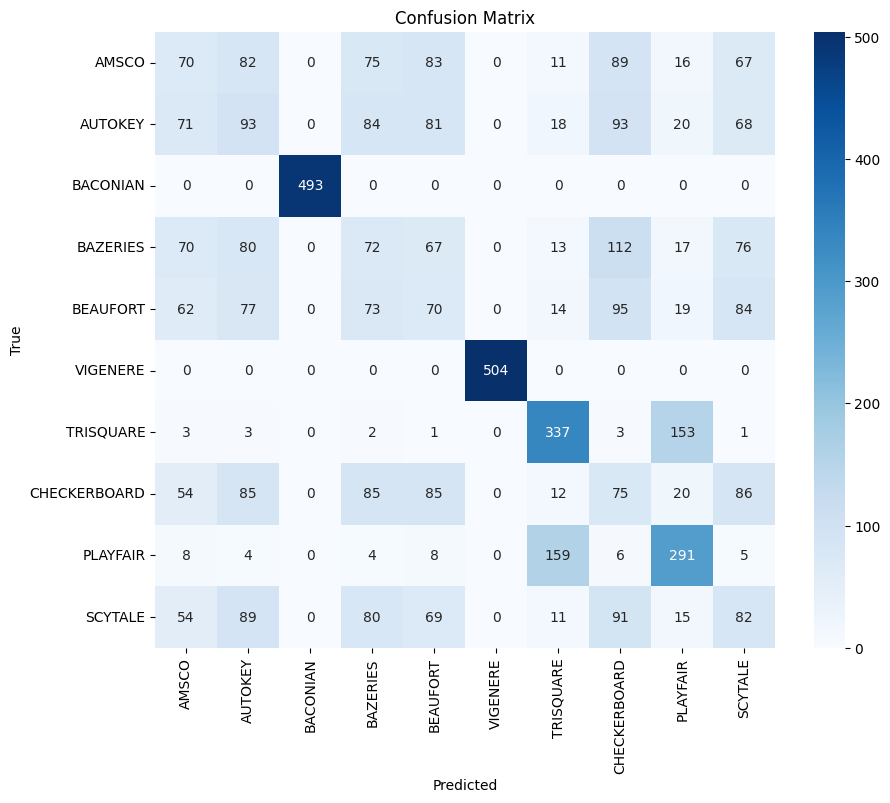

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=algorithms, yticklabels=algorithms)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
